In [1]:
import os
import torch
import pickle
from skimage import io
import matplotlib.pyplot as plt
from torchvision.models import resnet152
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Normalize, Resize, Rotate, HorizontalFlip, RandomCrop
from dataset import CustomDataset
# from model import DepthEstimationNet, ModifiedBlock
# from training import train_model, DBELoss, get_training_augmentation, get_validation_augmentation, setup_logging
# from fourier_analysis import FDC
from torch import optim
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import resnet152
import torch.nn.functional as F
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from albumentations import Compose, HorizontalFlip, Resize, Normalize, Rotate, RandomCrop
from albumentations.pytorch import ToTensorV2
from dataset import CustomDataset
# from model import DepthEstimationNet
import copy
import logging


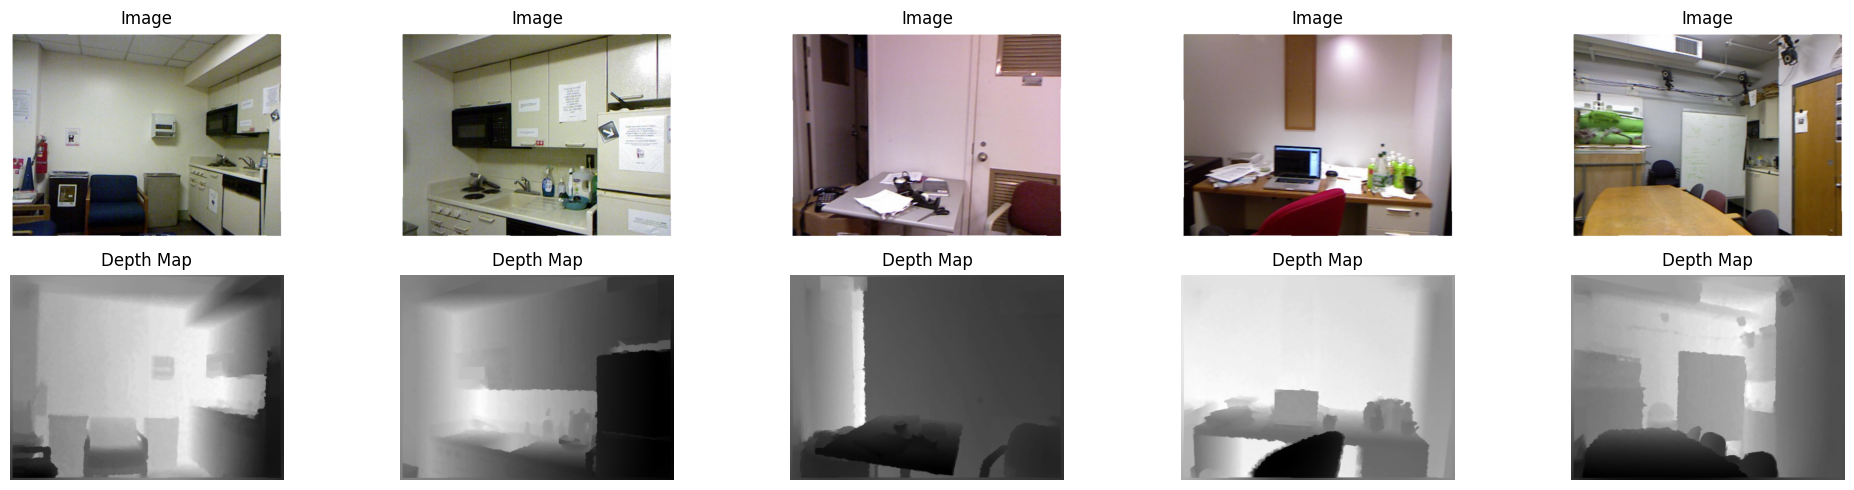

Image shape: (480, 640, 3)
Depth shape: (480, 640)


In [2]:
def display_samples(data_dir, num_samples=5):
    images_dir = os.path.join(data_dir, 'images/train')
    depths_dir = os.path.join(data_dir, 'depths/train')
    image_paths = sorted([os.path.join(images_dir, name) for name in os.listdir(images_dir) if name.endswith('.p')])
    depth_paths = sorted([os.path.join(depths_dir, name) for name in os.listdir(depths_dir) if name.endswith('.p')])

    plt.figure(figsize=(20, 5))
    for i in range(num_samples):
        image = pickle.load(open(image_paths[i], 'rb'))
        depth = pickle.load(open(depth_paths[i], 'rb'))
        
        # If images are floats in [0, 255] range, we need to convert to uint8
        image = image.astype('uint8')
        
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        # Display depth map - normalize to [0, 1] range for display purposes
        normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(normalized_depth, cmap='gray')
        plt.title('Depth Map')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

data_dir = './data/nyu_v2'
display_samples(data_dir)

# data shape
image = pickle.load(open('./data/nyu_v2/images/train/00000.p', 'rb'))
depth = pickle.load(open('./data/nyu_v2/depths/train/00000.p', 'rb'))
print(f'Image shape: {image.shape}')
print(f'Depth shape: {depth.shape}')

# expected output
# Image shape: (480, 640, 3)
# Depth shape: (480, 640)


In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


In [4]:
device

device(type='mps')

In [5]:
project_dir = os.getcwd()
save_dir = os.path.join(project_dir, 'models', 'training_runs')
os.makedirs(save_dir, exist_ok=True)
# setup_logging(save_dir)

## DepthModelNet

In [6]:
class ModifiedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device):
        super(ModifiedBlock, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1).to(self.device)
        self.bn1 = nn.BatchNorm2d(out_channels).to(self.device)
        self.relu = nn.ReLU(inplace=True).to(self.device)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1).to(self.device)
        self.bn2 = nn.BatchNorm2d(out_channels).to(self.device)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 1).to(self.device)
        self.bn3 = nn.BatchNorm2d(out_channels).to(self.device)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1).to(self.device) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.residual_conv is None else self.residual_conv(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x += residual
        x = self.relu(x)
        return x


In [7]:
class DepthEstimationNet(nn.Module):
    def __init__(self, num_aux_modules=16, aux_channels=16, device='cpu'):
        super(DepthEstimationNet, self).__init__()
        self.device = device
        base_resnet = resnet152(pretrained=True).to(self.device)
        self.features = nn.Sequential(*list(base_resnet.children())[:-2]).to(self.device)
        
        self.modified_blocks = nn.ModuleList(
            [ModifiedBlock(2048, 2048, self.device) for _ in range(num_aux_modules)]
        ).to(self.device)

        self.aux_convs = nn.ModuleList(
            [self._create_aux_module(2048, aux_channels) for _ in range(num_aux_modules)]
        ).to(self.device)

        # Adjusting the Depth Estimation Head for proper upscaling
        self.depth_head = nn.Sequential(
            nn.Conv2d(aux_channels * num_aux_modules, 256, 1).to(self.device),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1).to(self.device),  # Upscale to 14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1).to(self.device),  # Upscale to 28x28
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1).to(self.device),  # Upscale to 56x56
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1).to(self.device),  # Upscale to 112x112
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1).to(self.device),  # Upscale to 224x224
        ).to(self.device)

    def _create_aux_module(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1).to(self.device),
            nn.BatchNorm2d(out_channels).to(self.device),
            nn.ReLU(inplace=True).to(self.device)
        )

    def forward(self, x):
        x = x.to(self.device)
        x = self.features(x)

        aux_features = []
        for mod_block, aux_conv in zip(self.modified_blocks, self.aux_convs):
            x = mod_block(x)
            aux = aux_conv(x)
            aux_features.append(aux)

        x = torch.cat(aux_features, dim=1)
        depth_map = self.depth_head(x)
        return depth_map


In [8]:
# test the model inputs /outputs shaps
model = DepthEstimationNet(device=device)
# input shape is (batch_size, 3, 224, 224)
input_image = torch.rand(3, 3, 224, 224)
depth_map = model(input_image)
print("Output shape:", depth_map.shape)


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([3, 1, 224, 224])


## Training

In [9]:
from albumentations import Compose, Rotate, HorizontalFlip, RandomCrop, Resize, Normalize
from albumentations.pytorch import ToTensorV2

def get_training_augmentation():
    def train_transform(sample):
        image_transform = Compose([
            Rotate(limit=35, p=0.5),
            HorizontalFlip(p=0.5),
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            Normalize(),
            ToTensorV2(),
        ])
        
        depth_transform = Compose([
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            ToTensorV2(),
        ])
        
        # Apply transformations and ensure the output format is correct
        sample['image'] = image_transform(image=sample['image'])['image']
        sample['depth'] = depth_transform(image=sample['depth'])['image']
        return sample
    
    return train_transform

def get_validation_augmentation():
    def validate_transform(sample):
        image_transform = Compose([
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            Normalize(),
            ToTensorV2(),
        ])
        
        depth_transform = Compose([
            RandomCrop(height=427, width=561, always_apply=True),
            Resize(224, 224),
            ToTensorV2(),
        ])
        
        # Apply transformations and ensure the output format is correct
        sample['image'] = image_transform(image=sample['image'])['image']
        sample['depth'] = depth_transform(image=sample['depth'])['image']
        return sample
    
    return validate_transform

class AlbumentationsWrapper(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        # Apply the transformation
        augmented = self.transform(sample)
        return augmented


In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, save_dir, checkpoint_interval=5, early_stopping_patience=10,device='cpu'):
    best_loss = float('inf')
    model.to(device)
    early_stopping_counter = early_stopping_patience
    train_loss_history = []
    
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for batch in tqdm(dataloaders[phase], desc=f'{phase} Progress'):
                inputs = batch['image'].to(device)
                labels = batch['depth'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) if phase == 'train' else criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                print(f'{phase} Loss: {epoch_loss:.4f}')
            elif phase == 'val':
                scheduler.step(epoch_loss)
                print(f'{phase} Loss: {epoch_loss:.4f}')
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    early_stopping_counter = early_stopping_patience
                else:
                    early_stopping_counter -= 1
            if early_stopping_counter == 0:
                print('Early stopping triggered')
                break
            
        # checkpoint 
        if epoch % checkpoint_interval == 0:
            torch.save(model.state_dict(), os.path.join(save_dir, f'model_{epoch}.pth'))
            print(f'Checkpoint saved at model_{epoch}.pth')
        
                    
    print('trainning completed')
    return model
                    
                        
                    

In [11]:
class DBELoss(nn.Module):
    def __init__(self, a1=1.5, a2=-0.1, device=device):
        super(DBELoss, self).__init__()
        self.a1 = a1
        self.a2 = a2
        self.device = device

    def forward(self, estimated_depth, ground_truth_depth):
        estimated_depth = estimated_depth.to(self.device)
        ground_truth_depth = ground_truth_depth.to(self.device)
        diff = estimated_depth - ground_truth_depth
        balanced_diff = self.a1 * diff + self.a2 * torch.square(diff)
        return torch.mean(torch.square(balanced_diff))

In [12]:
# execute the training
# Load the dataset
# Correct variable
data_dir = './data/nyu_v2'

# Correct dataset instantiation
train_dataset = CustomDataset(dataset_path=data_dir, transform=AlbumentationsWrapper(get_training_augmentation()))
val_dataset = CustomDataset(dataset_path=data_dir, transform=AlbumentationsWrapper(get_validation_augmentation()))


In [13]:
print(train_dataset[0]['image'].shape)
print(train_dataset[0]['depth'].shape)

print(val_dataset[0]['image'].shape)
print(val_dataset[0]['depth'].shape)

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [14]:

# Create dataloaders
model = DepthEstimationNet(device=device)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
loss_function = DBELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)



In [15]:
training_args = {
    'model': model,
    'dataloaders': dataloaders,
    'criterion': loss_function,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'num_epochs': 500,
    'save_dir': save_dir,
    'checkpoint_interval': 5,
    'early_stopping_patience': 50,
    'device': device
}


In [16]:
trained_model = train_model(**training_args)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/10 [00:29<?, ?it/s]


KeyboardInterrupt: 